# Imports

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
from collections import defaultdict, deque
from tqdm.notebook import tqdm
import gymnasium as gym

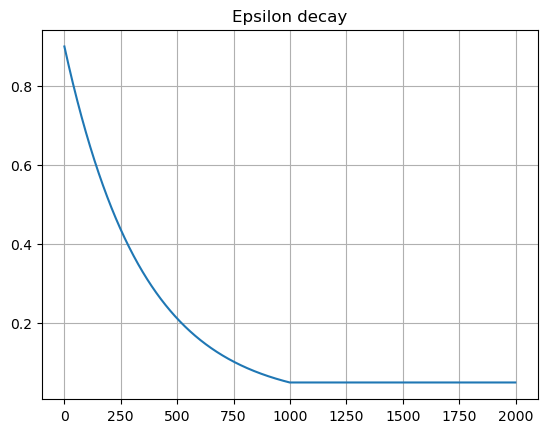

In [22]:
@torch.no_grad()
def eval(env, model, max_episodes, max_episode_steps, get_action_func):
    """
    Test model performance playing environment
    """
    model.eval()

    rewards = []
    steps = []
    for episode_i in range(max_episodes):

        rewards.append(0)
        steps.append(0)

        state, info = env.reset()

        for step_i in range(max_episode_steps):

            action = get_action_func(model, state)

            state, reward, terminated, truncated, info = env.step(action)

            rewards[-1] += reward
            steps[-1] += 1

            if terminated or truncated:
                break

    print(f"Eval: episodes {max_episodes}, average episode sum rewards {np.mean(rewards)}, std {np.std(rewards)}. Average number of steps {np.mean(steps)}, std {np.std(steps)}")

def show_train_curves(train_curves):
    """
    Show training curves with their moving average
    """
    fig, ax = plt.subplots(nrows=1, ncols=len(train_curves))
    fig.set_size_inches(25, 12)

    if len(train_curves) == 1:
        ax = [ax]

    for ci, (label, points) in enumerate(train_curves.items()):

        N = max(2, len(points) // 100)
        cumsum = np.cumsum(np.insert(points, 0, 0))
        moving_average = (cumsum[N:] - cumsum[:-N]) / float(N)

        ax[ci].plot(points, label=label)
        ax[ci].plot(moving_average, linewidth=1, color='r', label=f"Moving average using {N} points window")
        ax[ci].set_ylabel(label)
        ax[ci].legend()
        ax[ci].grid(True)



class ReplayMemory:
    """
    Store memory transitions (state, action, reward, next_state) and allow sampling it
    """
    def __init__(self, capacity):
        self.states = deque([], maxlen=capacity)
        self.actions = deque([], maxlen=capacity)
        self.rewards = deque([], maxlen=capacity)
        self.done_flags = deque([], maxlen=capacity)
        self.next_states = deque([], maxlen=capacity)

    def __deque_index_on_array(self, deq, I):
        return np.array([deq[i] for i in I])

    def observe(self, state, action, reward, done, next_state):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.done_flags.append(1 if done else 0)
        self.next_states.append(next_state)

    def sample_as_tensors(self, batch_size):
        I = np.random.choice(len(self.states), batch_size)
        S = torch.as_tensor(self.__deque_index_on_array(self.states, I))
        A = torch.as_tensor(self.__deque_index_on_array(self.actions, I))
        R = torch.as_tensor(self.__deque_index_on_array(self.rewards, I))
        D = torch.as_tensor(self.__deque_index_on_array(self.done_flags, I))
        NS = torch.as_tensor(self.__deque_index_on_array(self.next_states, I))
        return S, A, R, D, NS

    def __len__(self):
        return len(self.states)


class EpsilonExponentialDecay:
    """
    Implement function eps(time) which values are exponentially decaying, starting from value `start`, reaching value `end` after `steps` steps and keep value `end` afterwards
    """
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps

    def value(self, time):
        if time >= self.steps:
            return self.end

        # val(time) = a*b^time
        # val(0) = start
        #    => a*b^0 = start
        #    => a = start
        # val(steps - 1) = end
        #    => a*b^(steps - 1) = end
        #    => b^(steps - 1) = end / start
        #    => steps - 1 = log_b(end / start)
        #    => steps - 1 = log(end / start) / log(b)
        #    => log(b) = log(end / start) / (steps - 1)
        #    => b = exp( log(end / start) / (steps - 1) )
        b = math.exp( math.log(self.end / self.start) / (self.steps - 1) )
        return self.start * math.pow(b, time)


class DQN_Model(torch.nn.Module):
    """
    DQN Model which estimate Q(s, a)
    """
    def __init__(self, env):
        super().__init__()

        assert len(env.observation_space.shape) == 1

        self.ENV_STATE_SIZE = env.observation_space.shape[0]
        self.ENV_ACTIONS = env.action_space.n

        hidden_size = 64

        self.dqn_model = torch.nn.Sequential(
            torch.nn.Linear(self.ENV_STATE_SIZE, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, self.ENV_ACTIONS),
        )

    def forward(self, state):
        B = state.shape[0]  # batch size
        assert state.shape == (B, self.ENV_STATE_SIZE)

        action_values = self.dqn_model(state)
        return action_values

    def forward_numpy_one_state(self, state):
        assert state.shape == (self.ENV_STATE_SIZE,)

        action_values = self.dqn_model(torch.from_numpy(state.reshape((1, -1)))).detach().cpu().numpy()[0, :]
        return action_values


def show_epsilon_decay():
    decay = EpsilonExponentialDecay(start=0.9, end=0.05, steps=1000)
    plt.plot([decay.value(time) for time in range(2000)])
    plt.title('Epsilon decay')
    plt.grid()


show_epsilon_decay()

# DQN on LunarLander

Implementation based on: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

  0%|          | 0/5000 [00:00<?, ?it/s]

Eval: episodes 100, average episode sum rewards 159.12084228421088, std 102.45051914619346. Average number of steps 515.56, std 292.4341744735044


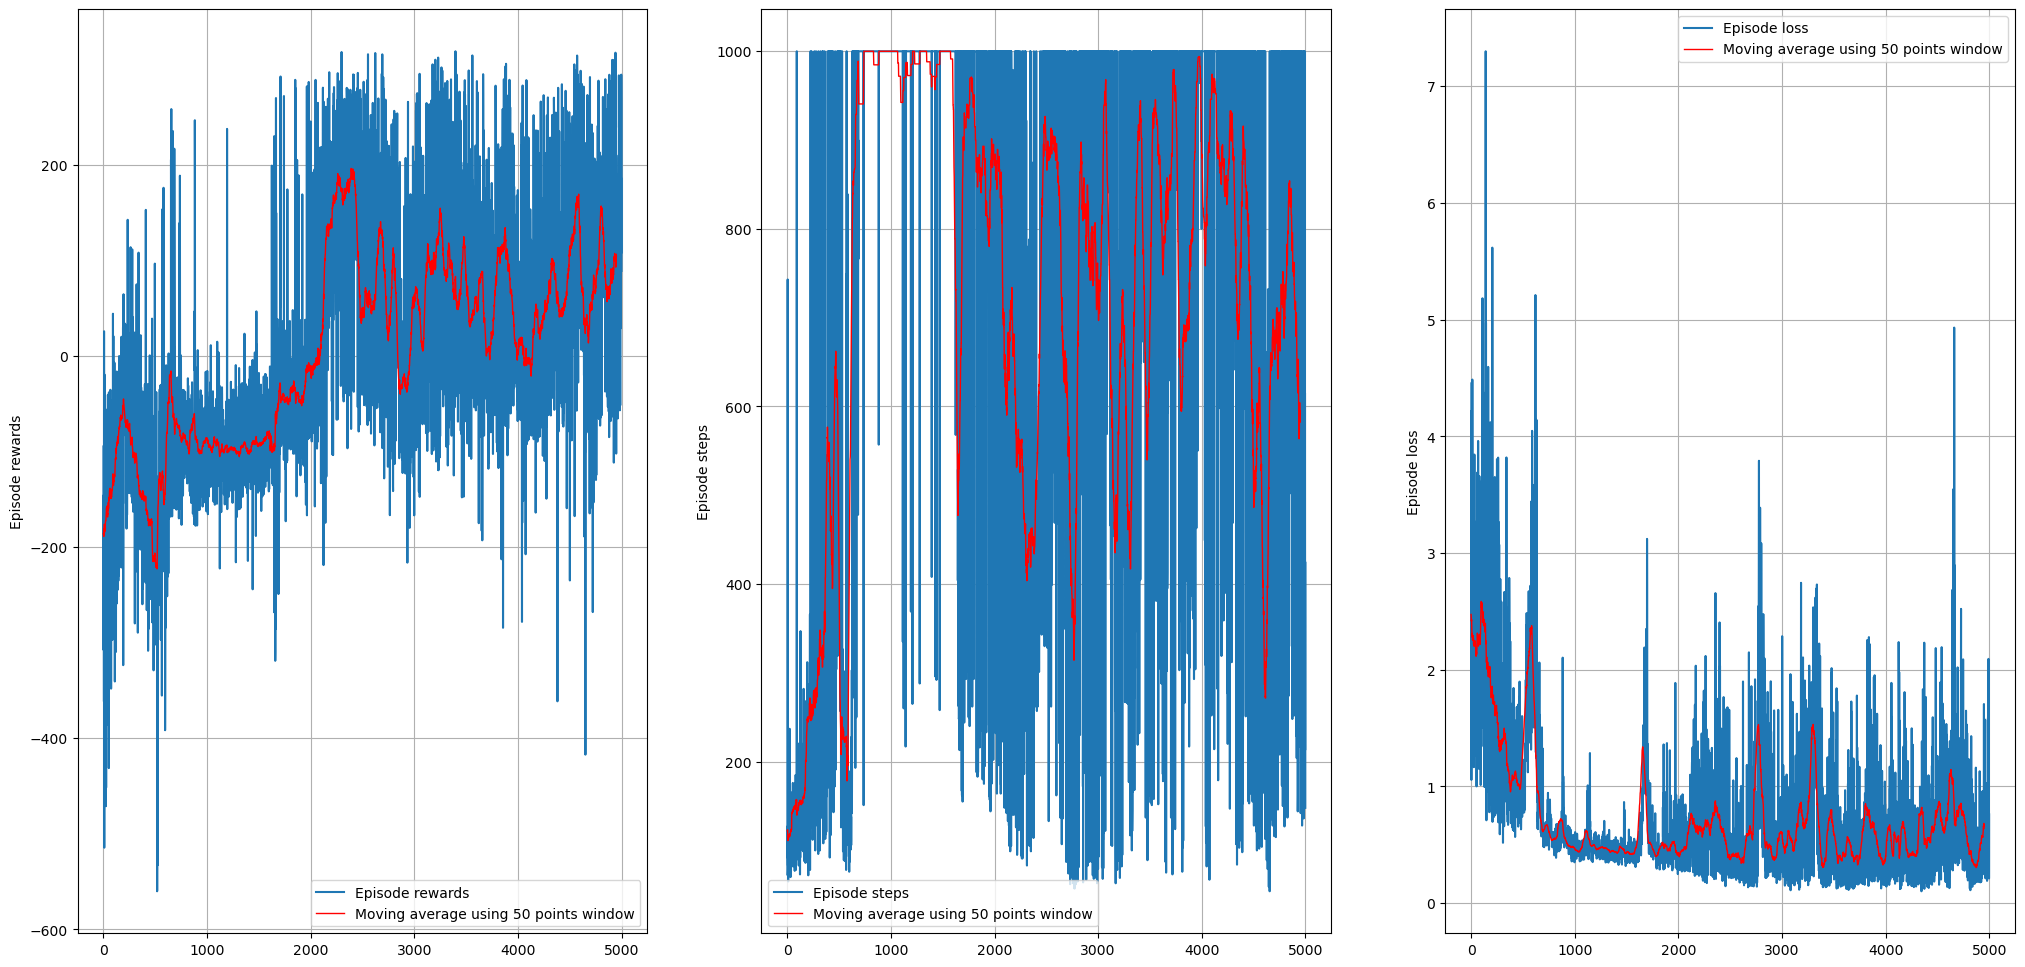

In [41]:
def dqn_impl(env, learning_rate, discount_factor, batch_size, memory_capacity, max_episodes, max_episode_steps):
    dqn_model = DQN_Model(env)

    dqn_optimizer = torch.optim.AdamW(dqn_model.parameters(), lr=learning_rate)

    epsilon_decay = EpsilonExponentialDecay(start=0.9, end=0.05, steps=1000)

    experience_replay = ReplayMemory(capacity=memory_capacity)

    train_curves = defaultdict(list)

    for episode_i in tqdm(range(max_episodes)):
        log_episode_reward = 0
        log_episode_steps = 0

        dqn_model.eval()
        with torch.no_grad():

            state, info = env.reset()

            for step_i in range(max_episode_steps):

                if np.random.rand() <= epsilon_decay.value(episode_i):
                    action = np.random.randint(0, dqn_model.ENV_ACTIONS)

                else:
                    action_values = dqn_model.forward_numpy_one_state(state)
                    action = np.argmax(action_values)

                next_state, reward, terminated, truncated, info = env.step(action)

                log_episode_reward += reward
                log_episode_steps += 1

                if truncated:
                    # Don't learn on truncated transition - they aren't true terminal states
                    break

                if terminated:
                    next_state = np.zeros_like(state)

                experience_replay.observe(state, action, reward, terminated, next_state)

                if terminated:
                    break

                state = next_state

            S, A, R, D, NS = experience_replay.sample_as_tensors(batch_size)
            # print("S", S.shape, S.dtype)     # S torch.Size([batch_size, 8]) torch.float32
            # print("A", A.shape, A.dtype)     # A torch.Size([batch_size]) torch.int64
            # print("R", R.shape, R.dtype)     # R torch.Size([batch_size]) torch.float64
            # print("D", D.shape, D.dtype)     # D torch.Size([batch_size]) torch.int64
            # print("NS", NS.shape, NS.dtype)  # NS torch.Size([batch_size, 8]) torch.float32

            next_state_values = dqn_model(NS).max(1).values   # still in eval - no gradient goes here
            next_state_values *= (1 - D)   # zero value where state was terminal and next state was zeroed
            # print("next_state_values", next_state_values.shape, next_state_values.dtype)

        dqn_model.train()

        state_all_action_values = dqn_model(S)
        # print("state_all_action_values", state_all_action_values.shape, state_all_action_values.dtype)

        state_action_values = state_all_action_values.gather(1, A.unsqueeze(1)).squeeze()
        # print("state_action_values", state_action_values.shape, state_action_values.dtype)

        expected_state_action_values = R + discount_factor * next_state_values
        # print("expected_state_action_values", expected_state_action_values.shape, expected_state_action_values.dtype)

        loss = torch.nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values)  # Huber loss
        log_loss = loss.item()
        dqn_optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_value_(dqn_model.parameters(), 100)   # In-place gradient clipping
        dqn_optimizer.step()

        train_curves['Episode rewards'].append(log_episode_reward)
        train_curves['Episode steps'].append(log_episode_steps)
        train_curves['Episode loss'].append(log_loss)

    return dqn_model, dqn_model, train_curves

def solve():
    env = gym.make('LunarLander-v2')

    dqn_model, dqn_model, train_curves = dqn_impl(
        env=env,
        learning_rate=1e-2,
        discount_factor=0.99,
        batch_size=128,
        memory_capacity=10000,
        max_episodes=5000,
        max_episode_steps=1000)

    show_train_curves(train_curves)

    def __get_greedy_action_func(dqn_model, state):
        action_values = dqn_model(
            state=torch.Tensor(state.reshape((1, -1))),
        )
        action_values = action_values.detach().cpu().numpy()[0, :]
        return np.argmax(action_values)

    eval(
        env,
        dqn_model,
        max_episodes=100,
        max_episode_steps=1000,
        get_action_func=__get_greedy_action_func)

    return env, dqn_model, dqn_model

env, dqn_model, dqn_model = solve()

## Use two networks for stability

Same algorithm as in cell above, but here we have two equal DQN models:

* Policy model (named `dqn_model` in the implementation below) - used for navigation and being trained

* Target model - this model is used only in computing Q values of the next state, when we need to compute `R + Q(next_state, action)` during training. Target model is soft-updated version of policy model

  0%|          | 0/10000 [00:00<?, ?it/s]

Eval: episodes 100, average episode sum rewards 104.94085361382804, std 115.25729662199575. Average number of steps 697.39, std 243.73132318190042


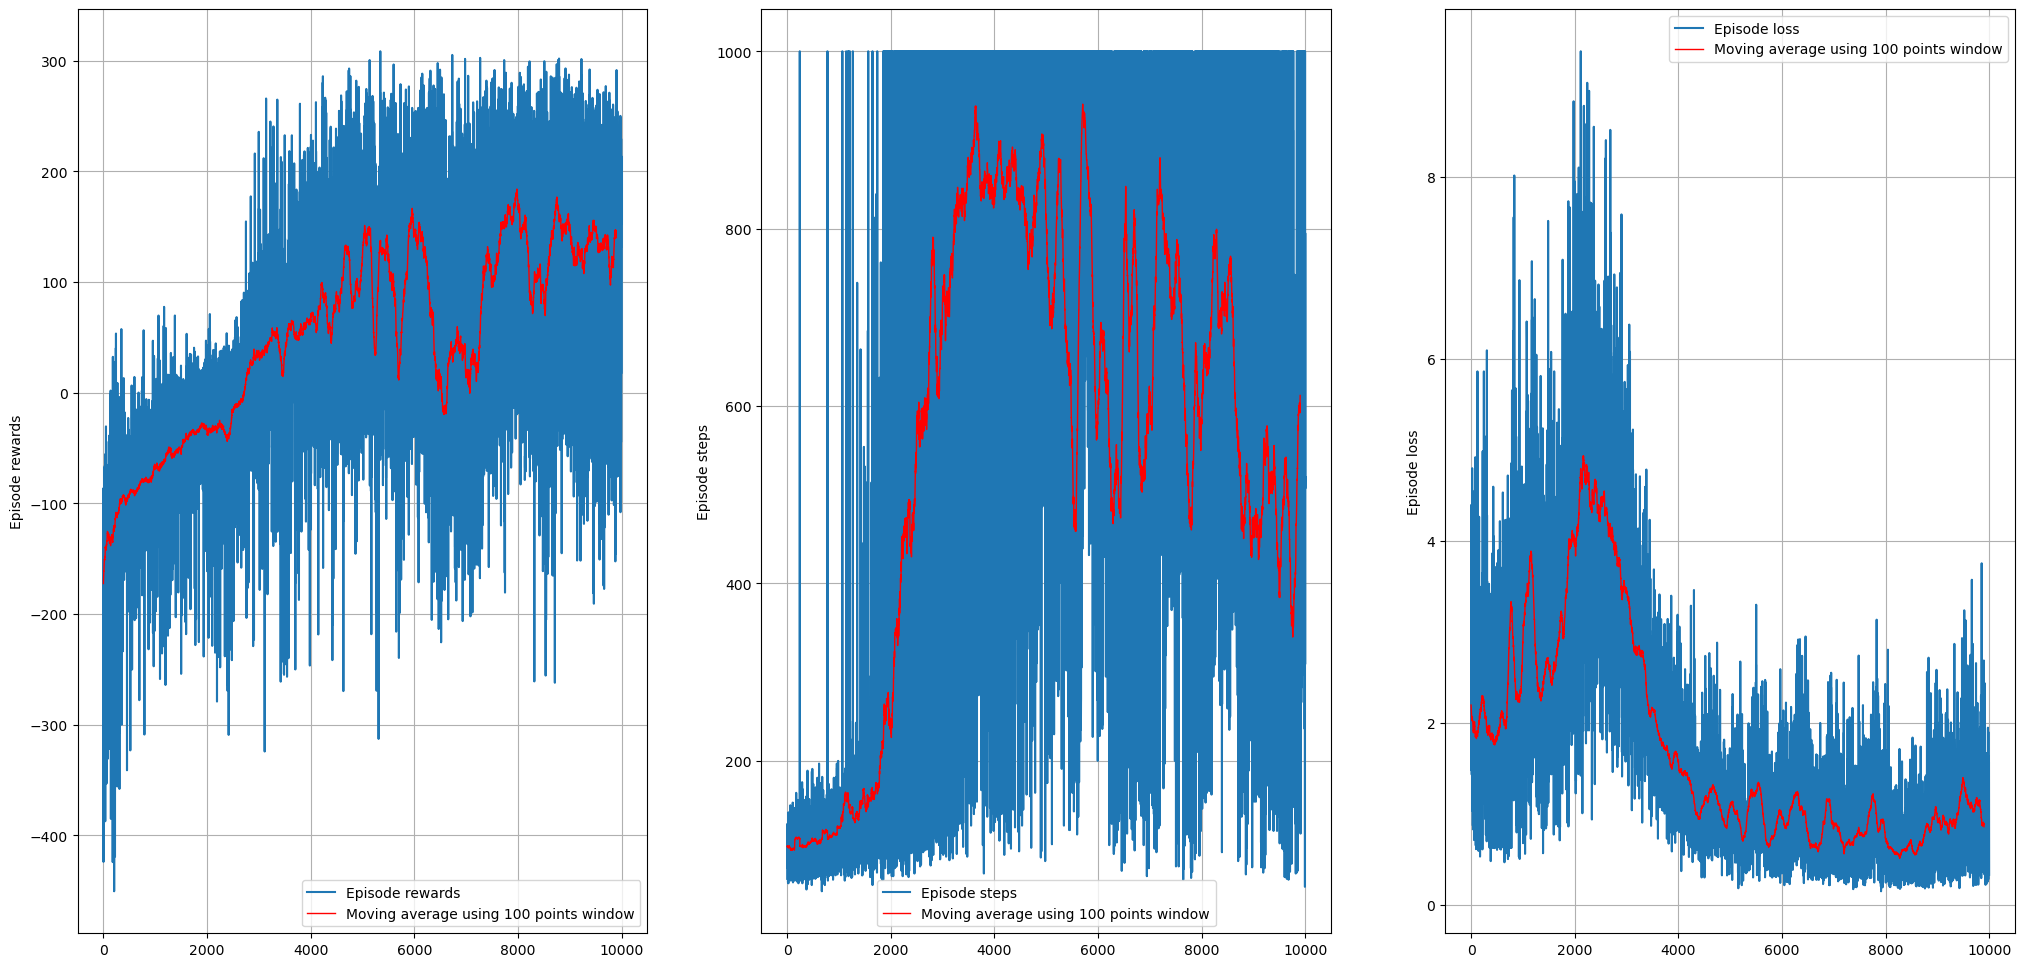

In [47]:
def dqn_impl(env, learning_rate, discount_factor, batch_size, memory_capacity, soft_update_tau, max_episodes, max_episode_steps):
    dqn_model = DQN_Model(env)
    target_model = DQN_Model(env)
    target_model.load_state_dict(dqn_model.state_dict())
    target_model.eval()   # Never being trained, its parameters are moving average of the policy model (`dqn_model`) parameter values

    dqn_optimizer = torch.optim.AdamW(dqn_model.parameters(), lr=learning_rate)

    epsilon_decay = EpsilonExponentialDecay(start=0.9, end=0.05, steps=max_episodes)

    experience_replay = ReplayMemory(capacity=memory_capacity)

    train_curves = defaultdict(list)

    for episode_i in tqdm(range(max_episodes)):
        log_episode_reward = 0
        log_episode_steps = 0

        dqn_model.eval()

        with torch.no_grad():

            state, info = env.reset()

            for step_i in range(max_episode_steps):

                if np.random.rand() <= epsilon_decay.value(episode_i):
                    action = np.random.randint(0, dqn_model.ENV_ACTIONS)

                else:
                    action_values = dqn_model.forward_numpy_one_state(state)
                    action = np.argmax(action_values)

                next_state, reward, terminated, truncated, info = env.step(action)

                log_episode_reward += reward
                log_episode_steps += 1

                if truncated:
                    # Don't learn on truncated transition - they aren't true terminal states
                    break

                if terminated:
                    next_state = np.zeros_like(state)

                experience_replay.observe(state, action, reward, terminated, next_state)

                if terminated:
                    break

                state = next_state

            S, A, R, D, NS = experience_replay.sample_as_tensors(batch_size)
            # print("S", S.shape, S.dtype)     # S torch.Size([batch_size, 8]) torch.float32
            # print("A", A.shape, A.dtype)     # A torch.Size([batch_size]) torch.int64
            # print("R", R.shape, R.dtype)     # R torch.Size([batch_size]) torch.float64
            # print("D", D.shape, D.dtype)     # D torch.Size([batch_size]) torch.int64
            # print("NS", NS.shape, NS.dtype)  # NS torch.Size([batch_size, 8]) torch.float32

            next_state_values = target_model(NS).max(1).values   # still in eval - no gradient goes here.
            next_state_values *= (1 - D)   # zero value where state was terminal and next state was zeroed
            # print("next_state_values", next_state_values.shape, next_state_values.dtype)

        dqn_model.train()

        state_all_action_values = dqn_model(S)
        # print("state_all_action_values", state_all_action_values.shape, state_all_action_values.dtype)

        state_action_values = state_all_action_values.gather(1, A.unsqueeze(1)).squeeze()
        # print("state_action_values", state_action_values.shape, state_action_values.dtype)

        expected_state_action_values = R + discount_factor * next_state_values
        # print("expected_state_action_values", expected_state_action_values.shape, expected_state_action_values.dtype)

        loss = torch.nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values)  # Huber loss
        log_loss = loss.item()
        dqn_optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_value_(dqn_model.parameters(), 100)   # In-place gradient clipping
        dqn_optimizer.step()

        target_model_state_dict = target_model.state_dict()
        dqn_model_state_dict = dqn_model.state_dict()
        for key in dqn_model_state_dict.keys():
            target_model_state_dict[key] = dqn_model_state_dict[key] * soft_update_tau + target_model_state_dict[key] * (1 - soft_update_tau)
        target_model.load_state_dict(target_model_state_dict)

        train_curves['Episode rewards'].append(log_episode_reward)
        train_curves['Episode steps'].append(log_episode_steps)
        train_curves['Episode loss'].append(log_loss)

    return dqn_model, dqn_model, train_curves

def solve():
    env = gym.make('LunarLander-v2')

    dqn_model, dqn_model, train_curves = dqn_impl(
        env=env,
        learning_rate=1e-2,
        discount_factor=0.99,
        batch_size=128,
        memory_capacity=10000,
        soft_update_tau=0.1,
        max_episodes=10000,
        max_episode_steps=1000)

    show_train_curves(train_curves)

    def __get_greedy_action_func(dqn_model, state):
        action_values = dqn_model(
            state=torch.Tensor(state.reshape((1, -1))),
        )
        action_values = action_values.detach().cpu().numpy()[0, :]
        return np.argmax(action_values)

    eval(
        env,
        dqn_model,
        max_episodes=100,
        max_episode_steps=1000,
        get_action_func=__get_greedy_action_func)

    return env, dqn_model, dqn_model

env, dqn_model, dqn_model = solve()